In [1]:
from sklearn import svm, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import svm, model_selection, preprocessing
from sklearn import neighbors
from sklearn import ensemble
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import probplot
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import missingno as msno


df = pd.read_csv("hmeq.csv")

df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [3]:
for col in df.columns:
    print (f"La colonne {col} a {df[col].nunique()} modalités")
    
# On vire les colonnes qui n'ont qu'une modalité (pouvoir prédictif inexistant)
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

La colonne BAD a 2 modalités
La colonne LOAN a 540 modalités
La colonne MORTDUE a 5053 modalités
La colonne VALUE a 5381 modalités
La colonne REASON a 2 modalités
La colonne JOB a 6 modalités
La colonne YOJ a 99 modalités
La colonne DEROG a 11 modalités
La colonne DELINQ a 14 modalités
La colonne CLAGE a 5314 modalités
La colonne NINQ a 16 modalités
La colonne CLNO a 62 modalités
La colonne DEBTINC a 4693 modalités


In [4]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


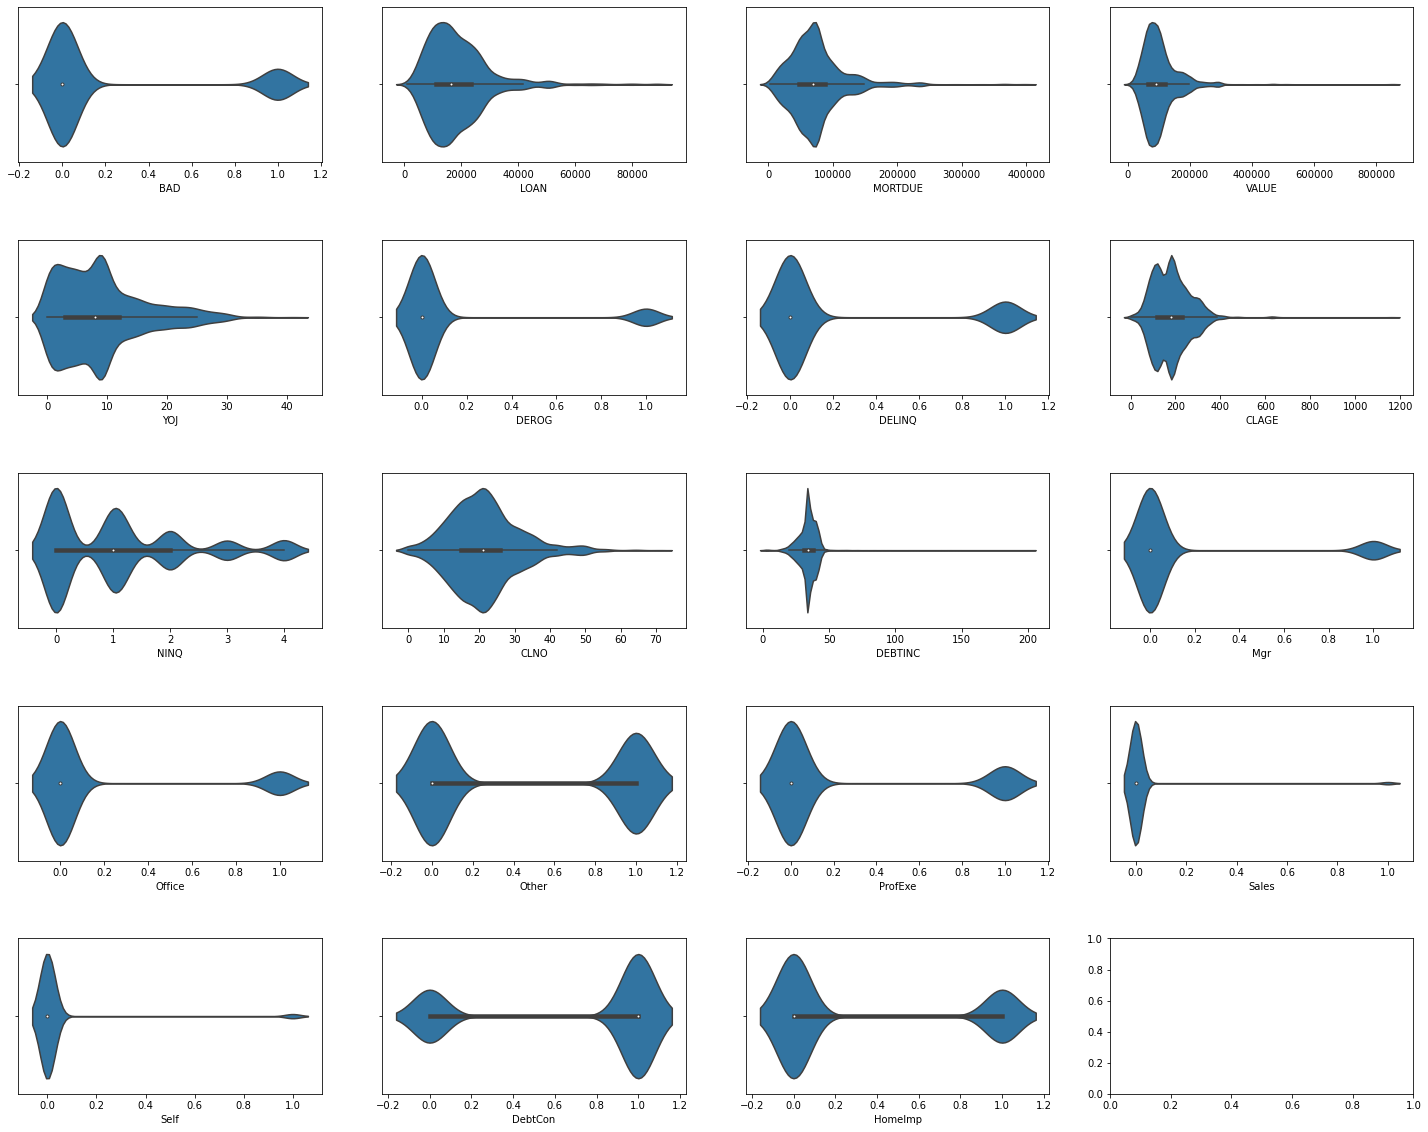

In [49]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20),)
for i,ax in zip(df.columns,axes.flat):
    sns.violinplot(data=df, x=i,ax=ax)     
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

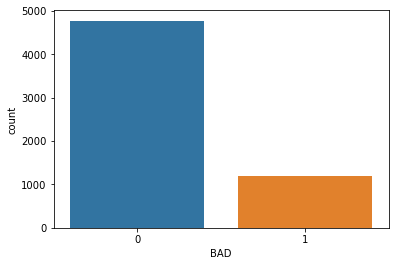

In [6]:
sns.countplot(x='BAD', data=df)

In [7]:
df['BAD'].value_counts()

0    4771
1    1189
Name: BAD, dtype: int64

In [8]:
df['BAD'].value_counts(normalize=1)

0    0.800503
1    0.199497
Name: BAD, dtype: float64

In [9]:
df.groupby('BAD').mean()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
BAD,,,,,,,,,,
0,19028.107315,74829.249055,102595.921018,9.154941,0.134217,0.245133,187.002355,1.032749,21.317036,33.253129
1,16922.119428,69460.452973,98172.846227,8.027802,0.707804,1.229185,150.190183,1.782765,21.211268,39.387645


In [10]:
df.groupby('BAD').median()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
BAD,,,,,,,,,,
0,16900,66839.0,90659.0,7.0,0.0,0.0,180.415787,1.0,20.0,34.541671
1,14900,60279.0,82000.0,6.0,0.0,0.0,132.866667,1.0,20.0,38.079762


In [11]:
((df.isnull().sum())/len(df)*100)

BAD         0.000000
LOAN        0.000000
MORTDUE     8.691275
VALUE       1.879195
REASON      4.228188
JOB         4.681208
YOJ         8.640940
DEROG      11.879195
DELINQ      9.731544
CLAGE       5.167785
NINQ        8.557047
CLNO        3.724832
DEBTINC    21.258389
dtype: float64

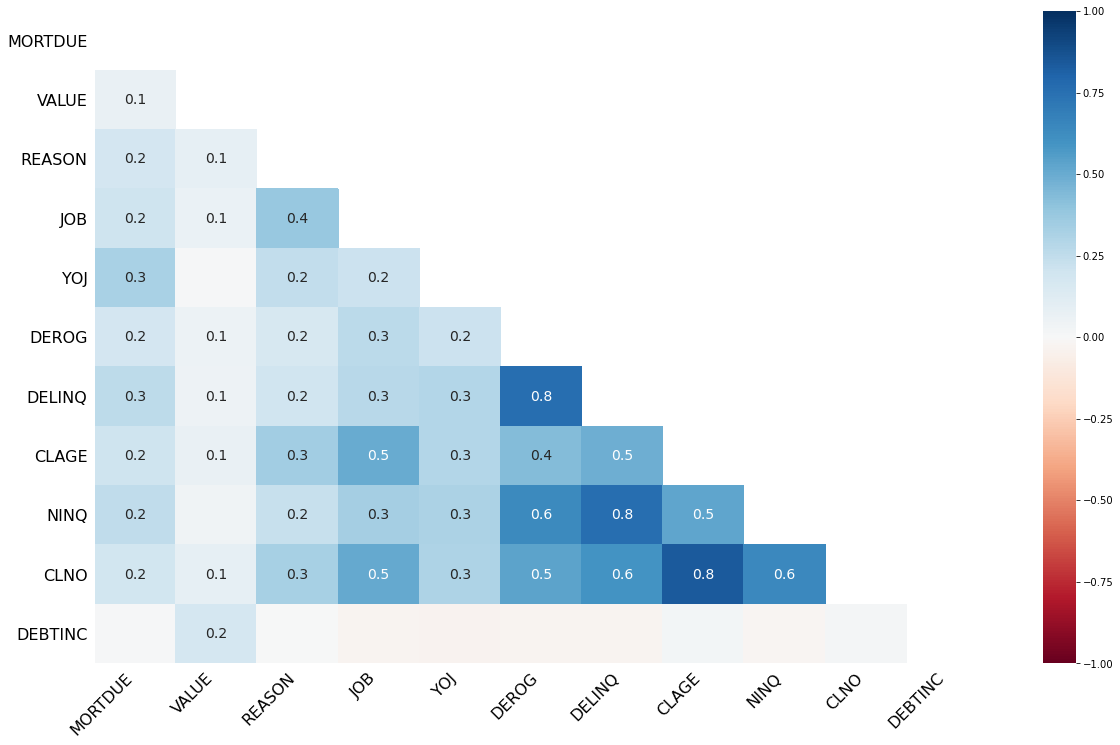

In [12]:
msno.heatmap(df)


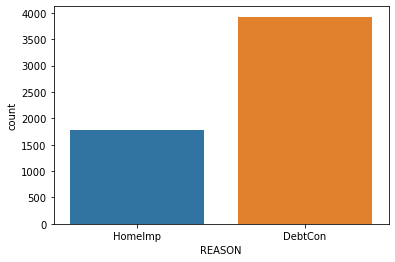

In [13]:
############################################
# VISUALISATION DE LA DISTRIBUTION         #
############################################

# On va d'abord visualiser les classes avec peu de modalités parmi celles qui en ont (des données manquantes) : REASON, JOB, DEROG, DELINQ et NINQ

# REASON et JOB sont des catégorielles
sns.countplot(x='REASON', data=df)


In [14]:
df['REASON'].value_counts(normalize=1)

DebtCon    0.688157
HomeImp    0.311843
Name: REASON, dtype: float64

In [15]:
# Il y a peu d'obs on pourrait penser à simplement virer les NA mais on va préférer remplacer par la classe majoritaire

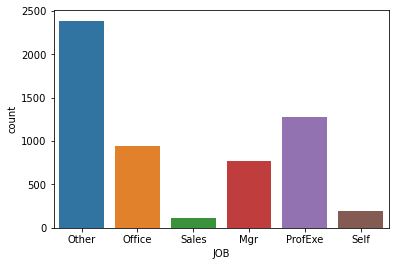

In [16]:
sns.countplot(x='JOB', data=df)

In [17]:
# Ici la classe dominante est "Other", étant donné sa nature càd classe dominante + le fait qu'elle ne désigne rien en particulier elle peut naturellement inclure les NA. On va donc les remplacer par cette classe.
df['JOB'].value_counts(normalize=1)

Other      0.420349
ProfExe    0.224608
Office     0.166872
Mgr        0.135011
Self       0.033973
Sales      0.019187
Name: JOB, dtype: float64

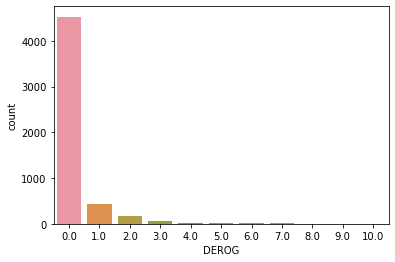

In [18]:
sns.countplot(x='DEROG', data=df)



In [19]:
# Ici aussi il n'y a pas photo la classe dominante est 0 et on préférera remplacer les NA par ce mode. Autre chose intéressante la distribution du nombre de DEROG (qui n'est pas une catégorielle) est telle qu'on peut douter
# de la capacité prédictive des individus pour un nombre précis. Il y a une sorte de scission entre ceux qui n'en ont pas et ceux qui en ont. On pourrait transformer cette variable en binaire (0=0 et 1=1 et +) 
df['DEROG'].value_counts(normalize=1)

0.0     0.861957
1.0     0.082826
2.0     0.030465
3.0     0.011043
4.0     0.004379
6.0     0.002856
5.0     0.002856
7.0     0.001523
8.0     0.001142
9.0     0.000571
10.0    0.000381
Name: DEROG, dtype: float64

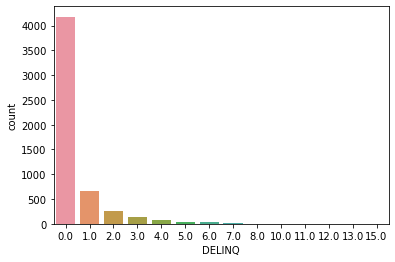

In [20]:
sns.countplot(x='DELINQ', data=df) 

In [21]:
# On peut tirer exactement les mêmes conclusions de la variable DELINQ
df['DELINQ'].value_counts(normalize=1)

0.0     0.776766
1.0     0.121561
2.0     0.046468
3.0     0.023978
4.0     0.014498
5.0     0.007063
6.0     0.005019
7.0     0.002416
8.0     0.000929
11.0    0.000372
10.0    0.000372
13.0    0.000186
12.0    0.000186
15.0    0.000186
Name: DELINQ, dtype: float64

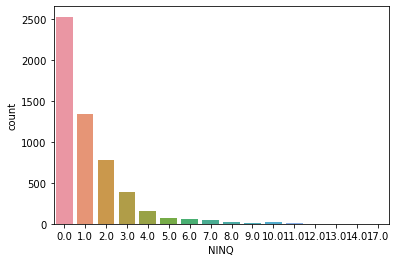

In [22]:
sns.countplot(x='NINQ', data=df) 

In [23]:
# Ici le nombre d'observations pour les valeurs 1 à 2 voire 3 est non négligeable, créer une binaire n'est peut-être pas la meilleure des solutions.
df['NINQ'].value_counts(normalize=1)

0.0     0.464404
1.0     0.245688
2.0     0.143119
3.0     0.071927
4.0     0.028624
5.0     0.013761
6.0     0.010275
7.0     0.008073
10.0    0.005138
8.0     0.004037
9.0     0.002018
11.0    0.001835
13.0    0.000367
12.0    0.000367
17.0    0.000183
14.0    0.000183
Name: NINQ, dtype: float64

In [24]:
############################################
# Traitement des données manquantes        #
############################################

# On va donc d'abord remplacer par le mode pour les binaires
df['DEROG'].fillna(value=0, inplace=True)
df['DELINQ'].fillna(value=0, inplace=True)

df["JOB"].fillna(df["JOB"].mode()[0],inplace=True) # JOB est une variable binaire de type string ici on remplace les NA par la classe dominante "Other"

df["REASON"].fillna(df["REASON"].mode()[0],inplace=True) # Même chose pour REASON avec la classe "DebtCon"

df.fillna(value=df.mean(),inplace=True) # Et on vérifie si les NA ne sont plus présents


In [25]:
df['REASON'].value_counts(normalize=1)

DebtCon    0.701342
HomeImp    0.298658
Name: REASON, dtype: float64

In [26]:
((df.isnull().sum())/len(df)*100)

BAD        0.0
LOAN       0.0
MORTDUE    0.0
VALUE      0.0
REASON     0.0
JOB        0.0
YOJ        0.0
DEROG      0.0
DELINQ     0.0
CLAGE      0.0
NINQ       0.0
CLNO       0.0
DEBTINC    0.0
dtype: float64

In [27]:
# Comme dit précédemmment on va dualiser les variables DEROG et DELINQ entre ceux qui ont eu un incident (1 et/ou +) et ceux qui n'en n'ont jamais eu (0).

df['DEROG'].values[df['DEROG'] > 1] = 1
df['DELINQ'].values[df['DELINQ'] > 1] = 1 
df['NINQ'].values[df['NINQ'] > 4 ] = 4

In [28]:
# On dichotomise les variables catégorielles
dummy_JOB = pd.get_dummies(df["JOB"])
dummy_REASON = pd.get_dummies(df["REASON"])
df = df.join(dummy_JOB)
df = df.join(dummy_REASON)
df.drop(["JOB","REASON"],axis=1,inplace=True)

In [29]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,Mgr,Office,Other,ProfExe,Sales,Self,DebtCon,HomeImp
0,1,1100,25860.0000,39025.000000,10.500000,0.0,0.0,94.366667,1.000000,9.000000,33.779915,0,0,1,0,0,0,0,1
1,1,1300,70053.0000,68400.000000,7.000000,0.0,1.0,121.833333,0.000000,14.000000,33.779915,0,0,1,0,0,0,0,1
2,1,1500,13500.0000,16700.000000,4.000000,0.0,0.0,149.466667,1.000000,10.000000,33.779915,0,0,1,0,0,0,0,1
3,1,1500,73760.8172,101776.048741,8.922268,0.0,0.0,179.766275,1.186055,21.296096,33.779915,0,0,1,0,0,0,1,0
4,0,1700,97800.0000,112000.000000,3.000000,0.0,0.0,93.333333,0.000000,14.000000,33.779915,0,1,0,0,0,0,0,1


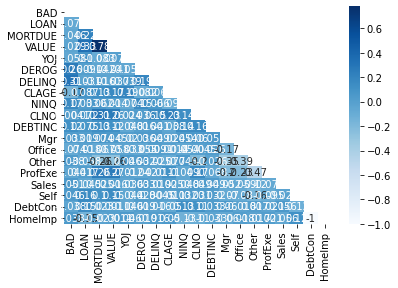

In [30]:
#### Corrélation ####
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="Blues", annot=True)

In [31]:
# Pas de valeur extrême (à part VALUE et LOAN mais pas assez) on ne drop rien

In [32]:
#####################################################
# REGRESSION LOGISTIQUE                             #
#####################################################


# Séparation entre matrice de design et target

data = df.drop('BAD', axis=1)
target = df['BAD']

# Entraînement

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [33]:
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,0,1
Classe réelle,,
0,937,1
1,251,3


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       938
           1       0.75      0.01      0.02       254

    accuracy                           0.79      1192
   macro avg       0.77      0.51      0.45      1192
weighted avg       0.78      0.79      0.70      1192



In [35]:
# Prédit très bien les 0 mais pas du tout les 1

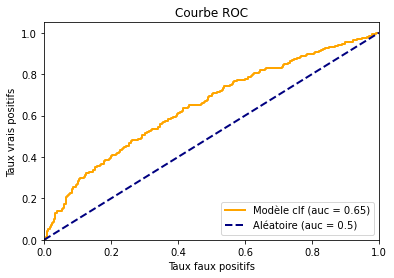

In [36]:
# AUROC
probs = clf.predict_proba(X_test)
fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();


In [37]:
#################
# RANDOM FOREST #
#################

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=12)
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321) # n_jobs =-1 tous les coeurs du CPU sont utilisés
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [38]:
y_pred = clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,923,18
1,73,178


In [39]:
clf.score(X_test, y_test)

0.9236577181208053

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       941
           1       0.91      0.71      0.80       251

    accuracy                           0.92      1192
   macro avg       0.92      0.85      0.87      1192
weighted avg       0.92      0.92      0.92      1192



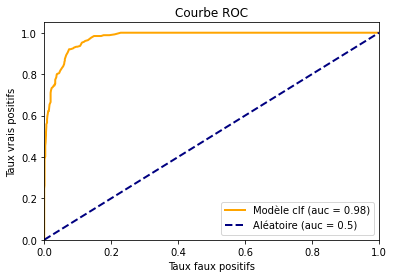

In [41]:
# AUROC
probs = clf.predict_proba(X_test)
fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();

In [42]:
parametres = {'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'], 
              'n_estimators': list(range(100,500,100)),}

In [43]:
grid_rf = model_selection.GridSearchCV(clf, param_grid=parametres)
grille_rf = grid_rf.fit(X_train,y_train)

print(pd.DataFrame.from_dict(grille_rf.cv_results_).loc[:,['params', 'mean_test_score']]) 


                                               params  mean_test_score
0   {'criterion': 'gini', 'max_features': 'auto', ...         0.914639
1   {'criterion': 'gini', 'max_features': 'auto', ...         0.915477
2   {'criterion': 'gini', 'max_features': 'auto', ...         0.916526
3   {'criterion': 'gini', 'max_features': 'auto', ...         0.916106
4   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.914639
5   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.915477
6   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.916526
7   {'criterion': 'gini', 'max_features': 'sqrt', ...         0.916106
8   {'criterion': 'gini', 'max_features': 'log2', ...         0.914639
9   {'criterion': 'gini', 'max_features': 'log2', ...         0.915477
10  {'criterion': 'gini', 'max_features': 'log2', ...         0.916526
11  {'criterion': 'gini', 'max_features': 'log2', ...         0.916106
12  {'criterion': 'entropy', 'max_features': 'auto...         0.910442
13  {'

In [44]:
print(grid_rf.best_params_)

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 300}


In [45]:
y_pred = grid_rf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,923,18
1,73,178


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       941
           1       0.91      0.71      0.80       251

    accuracy                           0.92      1192
   macro avg       0.92      0.85      0.87      1192
weighted avg       0.92      0.92      0.92      1192



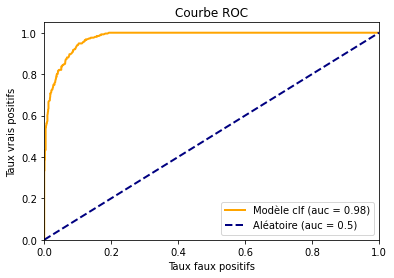

In [47]:
# AUROC
probs = grid_rf.predict_proba(X_test)
fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();

In [50]:
import time
import numpy as np

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time


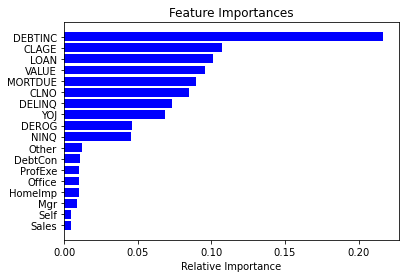

In [63]:
import pandas as pd

features = data.columns
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [35]:
###################
#      KNN        #
##################

knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

In [36]:
y_pred = knn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,910,28
1,215,39


In [37]:
knn_m = neighbors.KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_m.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan')

In [38]:
y_pred = knn_m.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,894,44
1,204,50


In [39]:
parametres = {'n_neighbors': list(range(1,31)), 'metric': ['manhattan', 'minkowski', 'chebyshev']}
grid_knn = model_selection.GridSearchCV(knn, param_grid=parametres)
grille_knn = grid_knn.fit(X_train,y_train)

In [40]:
print(pd.DataFrame.from_dict(grille_knn.cv_results_).loc[:,['params', 'mean_test_score']]) 


                                        params  mean_test_score
0    {'metric': 'manhattan', 'n_neighbors': 1}         0.781670
1    {'metric': 'manhattan', 'n_neighbors': 2}         0.823196
2    {'metric': 'manhattan', 'n_neighbors': 3}         0.810609
3    {'metric': 'manhattan', 'n_neighbors': 4}         0.824661
4    {'metric': 'manhattan', 'n_neighbors': 5}         0.819626
..                                         ...              ...
85  {'metric': 'chebyshev', 'n_neighbors': 26}         0.813548
86  {'metric': 'chebyshev', 'n_neighbors': 27}         0.811870
87  {'metric': 'chebyshev', 'n_neighbors': 28}         0.814178
88  {'metric': 'chebyshev', 'n_neighbors': 29}         0.813758
89  {'metric': 'chebyshev', 'n_neighbors': 30}         0.813339

[90 rows x 2 columns]


In [41]:
print(grid_knn.best_params_)

{'metric': 'manhattan', 'n_neighbors': 4}


In [42]:
y_pred = grid_knn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,913,25
1,216,38


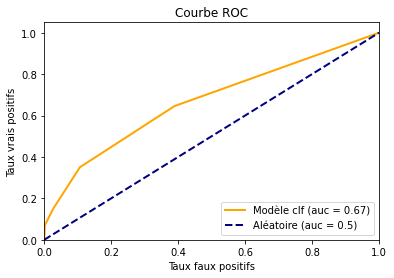

In [43]:
probs = grid_knn.predict_proba(X_test)
fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show();

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       938
           1       0.60      0.15      0.24       254

    accuracy                           0.80      1192
   macro avg       0.71      0.56      0.56      1192
weighted avg       0.76      0.80      0.75      1192

